## Purporse

Explore how to create good clusters using GMM:
- Look at the silhouette_score for different cluster number. This is for finding the right number of clusters.
- plot them using T-sne
- How do the cluster difference between each other.
- Look at the "representative of each cluster"

In [1]:
# pip install --upgrade "kaleido==0.1.*"

In [2]:
import plotly.io as pio
pio.renderers.default = "jpg"

In [3]:
import os
os.environ['OMP_NUM_THREADS'] = "6"
print(os.environ['OMP_NUM_THREADS'])

6


In [4]:
# import libraries

# the basic ones
import numpy as np
import pandas as pd

# Model
from sklearn.ensemble import RandomForestRegressor

# pipeline and column trasnformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Imputing numerical data
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# we will use this one (for categorical columns) to lower the amount of columns and work a little faster
from sklearn.preprocessing import TargetEncoder

# plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px

# To plot clusters in lower dimension
from sklearn.manifold import TSNE

# new library, we haven't used this one before in this repo
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score

In [5]:
# Read the data
# This data you can find here: https://www.kaggle.com/c/home-data-for-ml-course/data

X_full = pd.read_csv('train.csv', index_col='Id')

# SalePrice is the target, if there is no target eliminate row associated with it
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
X_full.reset_index(drop = True, inplace=True)
prices = X_full.SalePrice
X = X_full.copy()
X.drop(['SalePrice'], axis=1, inplace=True)


In [6]:
def transforming_clustering_gmm(X,y,n_components=3):
    
   # for Kmeans very useful to scale data. 
    columns_X = X.columns
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    

    numerical_transformer = Pipeline(
    steps=[("scaler1", StandardScaler()), ("imputer", KNNImputer(n_neighbors=3))
      ]
        )
    
    categorical_transformer =  Pipeline(steps=[
        ('encoder',TargetEncoder(smooth="auto",target_type='continuous')),
        ("scaler2", StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    gmm = GaussianMixture(n_components = n_components,max_iter=500,n_init=5,random_state=30) 
    # Bundle preprocessing and modeling code in a pipeline
    #pipe = Pipeline(steps=[('preprocessor', preprocessor)])
    
    # we need "y" because of TargetEncoder
    X_transform = preprocessor.fit_transform(X,y)
    gmm.fit(X_transform)
    df_transform = pd.DataFrame(X_transform,columns=columns_X)
    df_transform['clusters'] = gmm.predict(X_transform)
    df_transform_unscale = df_transform.copy()
    df_transform_unscale[numerical_col] = preprocessor.named_transformers_["numerical_transformer"].named_steps["scaler1"].inverse_transform(df_transform_unscale[numerical_col])
    df_transform_unscale[categorical_col] = preprocessor.named_transformers_["categorical_transformer"].named_steps["scaler2"].inverse_transform(df_transform_unscale[categorical_col])
    
    return  df_transform, df_transform_unscale, gmm

# Choosing the Right Number of Clusters

In [7]:
# I try very high number of cluster but we see that it just decrease.
import time
start_time = time.time()
number_clusters = [a for a in range(2,7)]
sil_list = []
silhoette_max = 0
index_max = -1
counter = 0
for clusters in number_clusters:
    df_transform, df_transform_unscale, gmm = transforming_clustering_gmm(X,prices,n_components=clusters)
    columns_without_clusters = [x for x in df_transform.columns if x not in ['clusters']]
    silhoette = silhouette_score(df_transform[columns_without_clusters],df_transform['clusters'])
    if silhoette > silhoette_max:
        silhoette_max = silhoette
        index_max = counter 
    counter = counter + 1
    sil_list.append(silhoette)

print(f" Seconds to run: {(time.time() - start_time)}")

 Seconds to run: 7.712712287902832


 the best score is with 0.13 with 2 number or clusters 


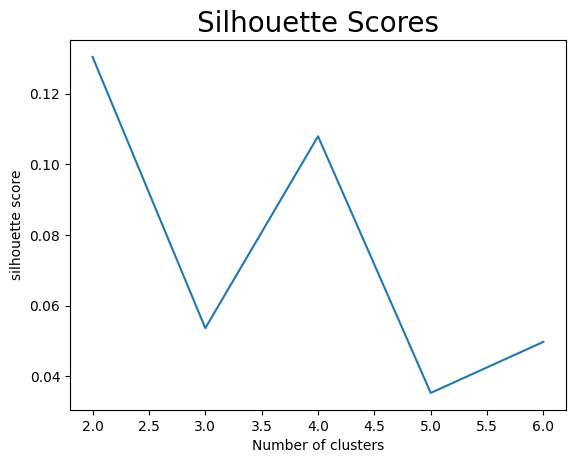

In [8]:
plt.plot(number_clusters, sil_list, '-')
plt.title("Silhouette Scores", fontsize=20)
plt.xlabel("Number of clusters")
plt.ylabel("silhouette score")
print(f" the best score is with {round(silhoette_max,2)} with {number_clusters[index_max]} number or clusters ")

Notice the score is very low. When the score is near to 0 that means that the points could have been easily assiged to another cluster. The maximum value that we could have is 1. Remeber also that in the previous notebook we saw that the t-sne didn't show well define clusters. We are going to plot this graph again but instead that doing against prices or "y" we are going to use the newly found clusters.

Probably in this case we won't find much in these cluster giving the low values we got at silhoette scores. But all the same let us build our functions and analysis.


# Plotting Cluster in a Lower Dimension

In [9]:
# we use the best number of clusters we got so far
df_transform, df_transform_unscale, gmm = transforming_clustering_gmm(X,prices,n_components=number_clusters[index_max])
# Let us use T-SNE that we use in the previous notebook to see how this cluster are doing.
tsne = TSNE(n_components=2,perplexity=5, random_state=42,learning_rate=1000,n_iter=5000)
X_tsne = tsne.fit_transform(df_transform)

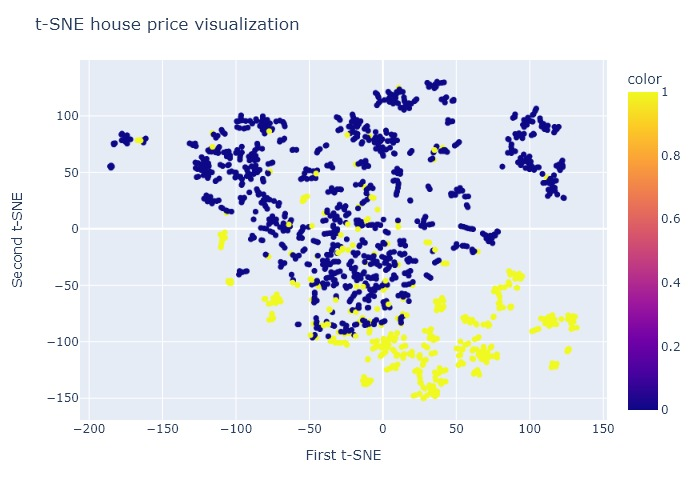

In [10]:
X_tsne = tsne.fit_transform(df_transform)
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=df_transform['clusters'])
fig.update_layout(
    title="t-SNE house price visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()
# images save in this folder
#fig.write(f"(2) GMM_tsne with 2 clusters.png")

So, good news! In a lower dimension done with T-SNE we can see that clusters are generally clump together.
So we need to know a little more now, for instance:
+ Giving some important feautures, how does each cluster center upon them?
+ do this clusters have statistical difference in the prices between each group?
+ What are the sizes of each cluster?

Here we will use the unscaled version of our dataframe because we want to print parallel_coordinates and for those we need to have a scaled X, because otherwise the y axis can vary too much on some columns/variables and not so much in others. The important aspect to grasp is how different the variables are in relationship with the clusters.

# General Clue About Each Cluster

In [11]:
# we could use this df_transform[df_transform['clusters']==0].mean() 
# or this: gmm.means_ to calculate the means, we are going to be efficient and use gmm.means_
columns_without_clusters = [x for x in df_transform.columns if x not in ['clusters']] 
def creating_dataframe_clusters_from_lists(lists,columns):
    df = pd.DataFrame(columns=columns)
    df.loc[len(df)] = lists[0]
    df['clusters'] = str("0")
    counter = 0
    for element in lists:
        if counter == 0:
            counter = counter + 1
            continue
        else:
            print(counter)
            new_list = list(lists[counter]) + list(str(counter))
            df.loc[len(df)] = new_list
            counter = counter + 1
    return df
        
    

In [12]:
df_centers = creating_dataframe_clusters_from_lists(gmm.means_,columns_without_clusters)
df_centers

1


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,clusters
0,-0.025697,0.074707,0.031992,0.270859,-0.059000,0.392692,0.258226,0.153891,0.158680,0.022065,...,0.300688,0.295606,0.306972,0.296852,-0.029719,0.050961,0.163093,0.119327,0.127267,0
1,0.061553,-0.154707,-0.076632,-0.648805,0.141327,-0.940641,-0.618545,-0.369252,-0.380097,-0.052855,...,-0.720257,-0.708084,-0.735310,-0.711068,0.071187,-0.122069,-0.390666,-0.285832,-0.304850,1


In [13]:
# This were the most important variables giving by permutation importance: 
# https://github.com/robertofuentesr/Useful_python_functions_ML/blob/main/(3)%20Insights%20in%20models/(1)%20Finding%20Important%20Columns.ipynb

dimensions=['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1','clusters']
df_centers[dimensions]

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,clusters
0,0.097134,0.120274,0.041974,-0.085339,0
1,-0.232671,-0.288100,-0.100543,0.204417,1


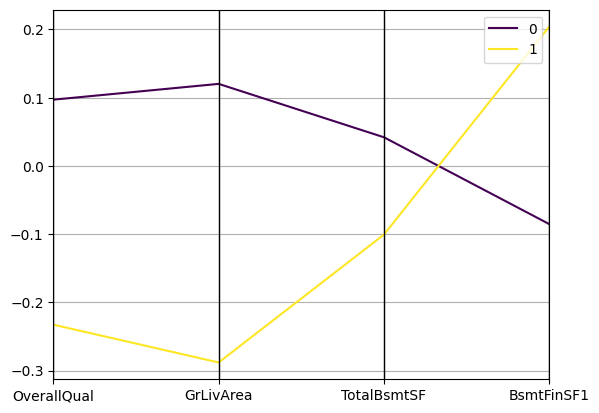

In [14]:
pd.plotting.parallel_coordinates(
    df_centers[dimensions] , 'clusters', colormap='viridis'
)  
print(" ")

Just looking at this graph, we see that cluster 1 has lower overall quality and the second variable, those were the most importance variables to explain the difference in price (We know this because of these notebooks: (3) Insights in models). So we expect to see lower values in prices for houses in cluster 1. 

If we just plot all the columns we have the following:

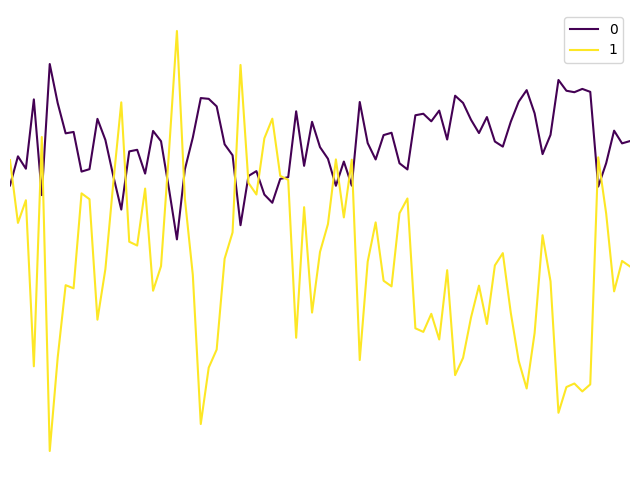

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.plotting.parallel_coordinates(
    df_centers, 'clusters', colormap='viridis',use_columns= False,axvlines = False,ax=ax)
plt.axis('off')
print(" ")

It looks like cluster 1 has in his vast majority the lowest values overall.

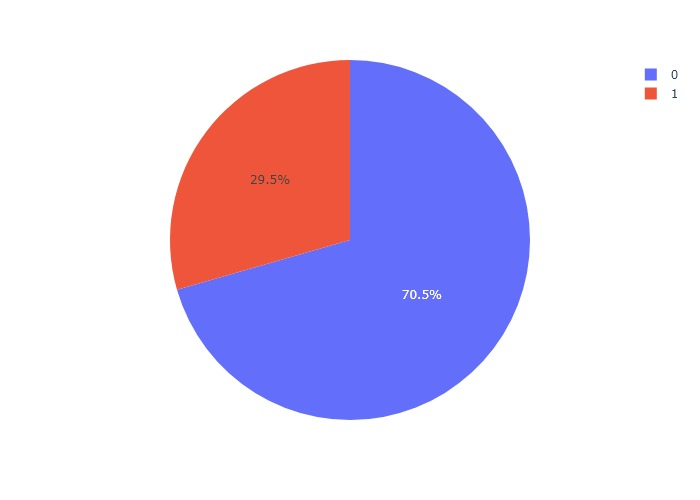

In [16]:
# just to plot 
df_transform['value_1'] = 1 
fig = px.pie(df_transform, values='value_1', names='clusters')
fig.show()
del df_transform['value_1'] 

So the vast majority of values belong to cluster 0

In [17]:
# Sklearn don't keep the indices so we need to add them back all of them 
# it is an old topic if you want to read about it: https://github.com/scikit-learn/scikit-learn/issues/8238
prices.reset_index(drop = True, inplace=True)

In [18]:
def difference_target_for_clusters(df_transform,y,clusters_str):
    """
    df_transform = DataFrame
    clusters_str = String that represents the name of the cluster's column
    """
    unique_clusters = list(df_transform[clusters_str].unique())
    dict_cluster_prices = {}
    for cluster in unique_clusters:
        cluster = str(cluster)
        index_cluster = df_transform[df_transform['clusters'] == int(cluster)].index
        dict_cluster_prices[cluster] = y[index_cluster].mean()
    return dict_cluster_prices

In [19]:
dict_cluster_prices = difference_target_for_clusters(df_transform,prices,"clusters")
dict_cluster_prices

{'0': 200717.2359223301, '1': 133502.77441860465}

So we were right! Cluster 1 has the lowest value houses.

Other important topics that we haven't mentioned yet, is that GMM gives us probabibility of being in a determine cluster.
One important aspects to ask ourselves is:

**What are the houses who most strongly belong to a determine cluster?**
That is the same that asking, what houses has the higher probability to belong to a determine cluster.

# Representative Each Cluster

In [20]:
from sklearn.metrics import silhouette_samples

In [21]:
df_transform['silhouette_score'] = silhouette_samples(df_transform[columns_without_clusters],df_transform['clusters'])

In [22]:
# let us get the most representative cases
def representative_clusters(df_transform,score_name):
    df_transform.sort_values(by = [score_name],ascending=False,inplace=True)
    df_transform.drop_duplicates(subset=['clusters'],inplace=True, keep='first')
    return df_transform

In [23]:
representatives = representative_clusters(df_transform,'silhouette_score')

In [24]:
representatives

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,clusters,silhouette_score
604,-0.872563,0.739457,0.229125,0.651479,-0.5172,1.017873,0.830215,-0.025885,1.049169,-0.288653,...,0.290166,0.293988,0.271766,-0.021421,0.433493,0.103490,-0.279463,-0.200175,0,0.333450
1218,-0.163109,-0.743573,-0.428632,-1.518467,-0.5172,-0.803768,-1.689368,-0.572835,-0.973018,-0.288653,...,-3.428986,-3.408354,-3.687096,-0.052571,0.409179,0.138474,-0.277421,-0.213373,1,0.097493


In [25]:
df_transform[df_transform['clusters']==1]['silhouette_score'].max()

0.09749283101490588

In [26]:
prices[representatives.index]

604     221000
1218     80500
Name: SalePrice, dtype: int64

So let us apreatiate the difference in house's prices between the representative of each class!
We could also tell a story of this particular house, what is it like to live there. But here I am interested of providing good analysis usind code the story teller even though is quite important, we left it to the reader!